# Plant pathology 2020

# Setting up env and downloading dataset

In [1]:
import os
from pathlib import Path

def check_environment() -> bool:
    """Check if the notebook is running in Google Colab or not.

    Returns:
        bool: True if running in Colab, False otherwise.
    """
    return bool(os.getenv("COLAB_RELEASE_TAG"))

def download_utils(colab_flag):
  """Function to clone the required utils .py helper module if running in colab

  Returns:
    None
  """
  if colab_flag:
    !curl -o /content/setup_utils.py https://raw.githubusercontent.com/jalkestrup/fastai_course/main/10_final_project/setup_utils.py
  else:
    return


In [2]:
colab_flag = check_environment()
download_utils(colab_flag)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3017  100  3017    0     0  10501      0 --:--:-- --:--:-- --:--:-- 10512


In [4]:
#Helper functions for setting up the environment and downloading the dataset based on compute environment
from setup_utils import install_libraries, download_kaggle_data, set_kaggle_credentials

install_libraries(colab_flag)

set_kaggle_credentials(colab_flag)

kaggle_dataset = 'plant-pathology-2020-fgvc7'
download_kaggle_data(kaggle_dataset)

Running in Colab...
...Installed required dependencies
Mounted at /content/drive/
Sucesfully set kaggle credentials
Data not detected, starting download


100%|██████████| 779M/779M [00:12<00:00, 63.2MB/s]


# Inspecting the data

In [5]:
import timm
from fastai.vision.all import *

path = Path('plant-pathology-2020-fgvc7')

image_path = path/'images'
image_files = get_image_files(image_path)

Shape of image : (1365, 2048)


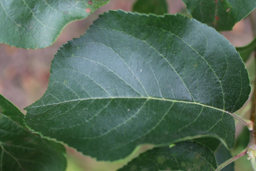

In [6]:
img = PILImage.create(image_files[3])
print(f'Shape of image : {img.shape}')
img.to_thumb(256)

The images are of similar size (1365 x 2048), but a few are rotated (2048x1365). To correct this we will create a new function that checks all images, and rotate those that are an exact transpose of the normal image-size. We may stil risk that the final test set contains images of a completely different size.



## Loading resized images
From previous script I have resized the images to 266x400 size, and saved them on Google Drive. We load these for experimentation

In [7]:
import multiprocessing
from fastcore.parallel import *

n_cores = multiprocessing.cpu_count()
print(f'Number of cores {n_cores}')

def check_size(img):
    return PILImage.create(img).shape

Number of cores 2


In [8]:
"""
dest = path/'medium_images'
resize_images(path/'images', max_size=400, dest=dest, recurse=True)

#Save resized images to drive for fast reload in new instance
Copy images from path/small_images to /content/drive/MyDrive/dtu/fastAI/10_final_project
!cp -r '/content/plant-pathology-2020-fgvc7/medium_images' /content/drive/MyDrive/dtu/fastAI/10_final_project
"""
#Copy prev resized images from drive to Colab
#Create new folder in /content/plant-pathology-2020-fgvc7/small_images
if colab_flag == True:
    !mkdir /content/plant-pathology-2020-fgvc7/small_images
    !cp -r /content/drive/MyDrive/dtu/fastAI/10_final_project/small_images/. '/content/plant-pathology-2020-fgvc7/small_images'
    #Check the size of a photo in the small_images
    image_path_small = path/'small_images'
    image_files_small = get_image_files(image_path_small)
    sizes = parallel(check_size, image_files_small, n_workers=n_cores)
    pd.Series(sizes).value_counts()
else:
    #For local dev (no GPU) make tiny images for faster training
    dest = path/'tiny_images'
    if not os.path.exists(dest):
        os.mkdir(dest)
        resize_images(path/'images', max_size=128, dest=dest, recurse=True)
    image_path_small = path/'tiny_images'
    image_files_small = get_image_files(image_path_small)
    sizes = parallel(check_size, image_files_small, n_workers=n_cores)
    pd.Series(sizes).value_counts()


## Setting up labels

In [9]:
#Inspect the labels of the dataset by loading the csv file into a pandas dataframe
df_train = pd.read_csv(f'{path}/train.csv')
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [10]:
#Create a new column with decoded labels for each image based on the one-hot encoded labels by using the np.argmax() function on column 2 to 5
#Set the label string in the new label column as the column name where the value is 1

df_train['label'] = df_train.apply(lambda col: df_train.columns[1:5][np.argmax(col.values[1:5])], axis=1)
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [11]:
df_train.label.value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

# Improving model performance
**In the notebook apple_disease.ipynb we have experimented with different models and img_tfms**, in this notebook we will continue the experimentation while focusing on the class inbalances  and methods to improve the performance of 2 selected models

**A note on fine-tuning**
All experiments thus far have conducted training via fine-tuning which uses the preexisting weights of the models (trained in imagenet 22k or 1K). Performance has been good, and training any of the considered models from scratch is not withing the scope of this assignment and would require much larger quantity of data and compute..

## Convext vs ViT
From previous experiments, see "model_arch_vs_loss.png" in the visualizations folder, it was concluded that the ViT_small_patch16_224 was the best performing model of the tested, and fastest to train, with beitv2_base also being a good but slower performing model, and convext_small performing 3rd best (visually estimated) and having fast training cycles.

This notebook will only look at the below 2 architectures:

**ViT - Vision Transformer (Google)**
This will be the base of experimenets.

As the name suggest this it NOT a convolutional NN architecture, but instead a transformer architecture based on the attention mechanism. Among best performing architectures and when introduced in 2020+ beat SOTA CNN based architectures. It expects a fixed image resolution: base model expects 224x224. https://arxiv.org/abs/2010.11929

**ConNeXt - Convolutional NN (Facebook)**
Inspired by vision transformers, ConvNext is a CNN model based purely on conv layers claimed to be a "modernized resnet" with the benefit of simplicty and scalability and accuracy that can compete with ViT models (authors note) https://arxiv.org/abs/2201.03545

In [12]:
#Function for collecting and emptying GPU Cache

if colab_flag:
    !pip install pynvml
    import gc
    def report_gpu():
        print(torch.cuda.list_gpu_processes())
        gc.collect()
        torch.cuda.empty_cache()

    report_gpu()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
GPU:0
no processes are running


## Class Inbalance
The dataset is inbalanced in that the multi label category has just ~100 images provided, whereas the 3 other categories has 600 samples provided. This can create problems for the model trained, which might scew the model towards this distribution that may not reflect reality.

### Adjusting loss function to tackle Class Inbalance

Default for of the vision learner for categorical variables, is **CrossEntropy**. Discussions indicate that **Dice score** could perform better for optimizing RoCAuC than CrossEntropy, but others claim that is not nescesarily so https://forums.fast.ai/t/using-auc-as-metric-in-fastai/38917 . Another option is to apply

**Weighting** * Weighting the loss function according to the inverse proportion of class frequency to emphasize loss from under represented samples. CrossEntropy can be weighted by passing a weight vector. In our case the were set to [0.1, 0.7, 0.1, 0.1] (~600 of each label except multi-class ~ 100. ~ 1900 total.)

**Focal Loss** which is a modification of cross entropy loss that scales the loss relative to confidence so that "easy examples" are automatically down-weighted https://paperswithcode.com/method/focal-loss. Further reading states "Focal loss is specialized for object detection with very unbalance classes" and might not be suitable for this task https://discuss.pytorch.org/t/focal-loss-performs-worse-than-cross-entropy-loss-in-clasification/139312/3

### Metric
According to kaggle competition, the score is "evaluated on **mean column-wise ROC AUC**", however as RoCAuC cannot be differentiated we can not use this as our loss function. ROC AUC is generally robust towards class-imbalance (predicting 99% as yellow if 99.5% of samples was yellow would not yield a good result).

RoCAuC can be added as a metric via FastAi, and the default setting of RocAuC is (axis=-1, average=macro, multi_glass=ovr) which matches the evaluation of the competition.

### Image augmentation
Augmenting images during training is an important parameter of training a robust image classifier. Per default fastAI aug_transform does rotations up to 10 deg, random flipping (p=0.5), zooms, variance of brightness and contrast, and for this task I have decided not to experiement with variations of these augmentations.

## Setting up W&B and model function

In [13]:
if colab_flag:
    !pip install -Uq wandb
    #Silence Wandb printouts
    os.environ["WANDB_SILENT"] = "true"
    import wandb
    wandb.login()
else:
    os.environ["WANDB_SILENT"] = "true"
    import wandb
    !wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

**Note to self on normalization** It is common to normalize the image data prior training, something that is even more important when using pretrained models. When using pretrained models the normalization should be based on the same statistics that the model was trained on. Using the Visionlearner from FastAI automatically take care of normalization, typically just based on ImageNet statistics.
```

### Problem of Wandb logging
Wandb currently logs the final score of the latest epoch, which is never the best score when using stop_early, often several % lower than the actual best model of this run.
For example convnext large reached 0.98 ROC score, but ended at 0.958 and reported this to wandb.

Implemented seperate function to iterate over the epochs and log the best ROC score as seperate metric

In [14]:
def best_loss_roc(rec):
  # Assuming the 0-th index is the training loss and the 1st index is the validation loss (adjust indices as needed)
  val_losses = [x[1] for x in rec.values]
  best_loss = min(val_losses)
  best_epoch = val_losses.index(min(val_losses))
  roc_scores = [x[2] for x in rec.values]
  best_roc = roc_scores[best_epoch]
  return best_loss, best_roc


In [15]:
#Function for easily swapping item transform and aug
#Added early stopping for longer train runs
from fastai.callback.wandb import *
from fastai.metrics import RocAuc

def train_model(arch, item, batch, epochs, batch_size=64, learning_rate=0.005, accum_steps=4, wandb_flag=False):

  config = {
      'arch': arch,
      'item_tfms_size': str(item.size),
      'item_tfms_method': item.method,
      'item_tfms_padding': item.pad_mode,
      'learning_rate': learning_rate,
      'epochs': epochs,
      'notes': 'None'
  }

  if wandb_flag:
    wandb.init(project='apple_disease', entity='jealk', group='model_architecture', config=config)

  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=item,
                               bs=batch_size//accum_steps,
                               batch_tfms=batch,
                               )

  loss_func = CrossEntropyLossFlat()

  learn = vision_learner(dls, arch, metrics=RocAuc(), pretrained=True, loss_func=loss_func).to_fp16()

  early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)

  callbacks = [early_stopping_cb, SaveModelCallback(monitor='valid_loss')]
  if wandb_flag:
    callbacks.append(WandbCallback(log=None,log_preds=False,log_model=False))

  if accum_steps > 1:
    gradient_accumulation_cb = GradientAccumulation(accum_steps)
    callbacks.append(gradient_accumulation_cb)

  learn.fine_tune(epochs,learning_rate, cbs=callbacks)

  if wandb_flag:
    recorder = learn.recorder
    min_loss, max_roc = best_loss_roc(recorder)
    wandb.log({"best_loss": min_loss})  # Logging the lowest loss value to wandb
    wandb.log({"best_roc": max_roc})  # Logging the ROC value of the lowest loss model to wandb
    wandb.finish()

  if wandb_flag:
    wandb.finish()

  return learn, dls


In [27]:
#By 'mistake' the ft_in1k' version was selected, however since using fine_tune unfreeze and retrains the latter layers,
#the fine_tune should not matter for the performance. For consistency on wandb I will keep the ft_in1k

learn,dls = train_model('vit_small_patch16_224.augreg_in21k_ft_in1k',
                          item=Resize(256, method='crop'),
                          batch=aug_transforms(size=224, min_zoom=0.75),
                          epochs=30,
                          wandb_flag=True)

report_gpu()

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.953151,0.490135,0.936528,00:14


Better model found at epoch 0 with valid_loss value: 0.49013468623161316.


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.445689,0.256387,0.972009,00:15
1,0.377166,0.221004,0.976328,00:16
2,0.266861,0.162138,0.981789,00:16
3,0.222105,0.164839,0.984772,00:16
4,0.256421,0.156943,0.984263,00:18
5,0.227052,0.151809,0.985839,00:16
6,0.209833,0.263653,0.972532,00:16
7,0.223559,0.236566,0.975086,00:16
8,0.184399,0.166554,0.982923,00:15


Better model found at epoch 0 with valid_loss value: 0.25638729333877563.
Better model found at epoch 1 with valid_loss value: 0.221003919839859.
Better model found at epoch 2 with valid_loss value: 0.16213756799697876.
Better model found at epoch 4 with valid_loss value: 0.1569429486989975.
Better model found at epoch 5 with valid_loss value: 0.15180860459804535.
No improvement since epoch 5: early stopping
GPU:0
process       4870 uses     2946.000 MB GPU memory


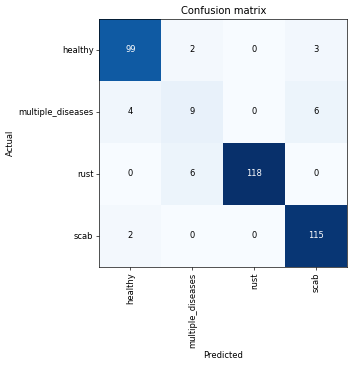

In [43]:
# Get predictions and targets for the validation set
interp = ClassificationInterpretation.from_learner(learn)
preds, targets = interp.top_losses()

# Plot the confusion matrix
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [29]:
# Saving the model
#/content/drive/MyDrive/dtu/fastAI/10_final_project
learn.export("/content/drive/MyDrive/dtu/fastAI/10_final_project/models/ViT_small_224_CEloss.pkl")

In [ ]:
#Inspect the model
#learn.summary()

## Conclusion: No clear increase in performance
- Weighted: as seen from "cross_entropy_loss_weighted_vs_roc.png" in the visualizations folder, there seem to be no consistent performance increase by weighting the loss function
![Alt text](image.png)
- Focal loss: As seen from "loss_functions_vs_roc.png" in the visualization folder, there does not seem to be a consistent RoC increase by using FocalLoss over regular Cross Entropy
![Alt text](image-1.png)

### Class inbalnace: Resampling training data
Another way to deal with the inbalanced dataset, would be to over or undersample the classes during training. However, for CV tasks it seems like there are varied opinions on whether an inbalance of this scale (1 to 6) negatively impacts training and performance of the model, https://forums.fast.ai/t/handling-class-imbalance-in-deep-learning-models/33054/2 . Hence for limiting the scope, I will not experiment with resampling, but the two used methods are:

*   Oversampling, taking more samples from the multi_disease labeled images during training
*   Unddersampling, taking fewer samples from the other labels during training (not a good option in our case as our training set is already small)


# Predicting on test set

In [36]:
#Load the list of test images into a pandas dataframe
df_test = pd.read_csv(f'{path}/test.csv')
df_test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


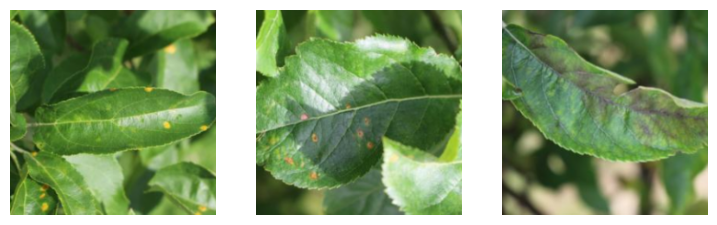

In [37]:
#Load the test images into a dataloader
test_dl = dls.test_dl(df_test)
test_dl.show_batch(max_n=3)

 **Regular prediction**


In [113]:
preds,_ = learn.get_preds(dl=test_dl)

In [39]:
preds[0:5]

tensor([[0.0239, 0.0456, 0.9168, 0.0137],
        [0.0146, 0.0189, 0.9563, 0.0102],
        [0.0215, 0.0124, 0.0093, 0.9568],
        [0.9785, 0.0049, 0.0099, 0.0066],
        [0.0065, 0.0054, 0.9850, 0.0030]])

### Predictions using TTA
Another approach is to use the same model and do multiple predictions on slightly augmented versions of each image sample, this is called test time augmentation. The predictions are then averaged to get the final prediction. This is a way to improve the accuracy of the model, but it comes at the cost of increased inference time.

In [38]:
preds,_ = learn.tta(dl=test_dl, n=4)

In [39]:
preds[0]

tensor([2.9806e-04, 3.9271e-03, 9.9577e-01, 6.9343e-06])

# Creating and submitting CSV to kaggle

In [40]:
#Append pd.DataFrame(preds) to the df_test dataframe
df_test = pd.concat([df_test, pd.DataFrame(preds)], axis=1)

#Set the column names to that of df_train labels
df_test.columns = df_train.columns[:5]
df_test.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000298,0.003927,9.957680e-01,6.934328e-06
1,Test_1,0.000100,0.007054,9.927493e-01,9.693574e-05
2,Test_2,0.000004,0.000004,4.154067e-07,9.999923e-01
3,Test_3,0.999342,0.000010,6.345976e-04,1.361996e-05
4,Test_4,0.000048,0.000045,9.999073e-01,2.593160e-07


In [41]:
#Create a csv file of the dataframe without the index column and save it on the root folder
df_test.to_csv('submission.csv', index=False)

In [42]:
from kaggle import api

api.competition_submit_cli('submission.csv', 'vit_small_patch16_224_CEloss_tta_run3', kaggle_dataset)

100%|██████████| 104k/104k [00:04<00:00, 24.5kB/s]


Successfully submitted to Plant Pathology 2020 - FGVC7

# Using larger models

To improve performance I experiment with a larger model of the ViT Transformer, and the previous Convext model that also performed well in the initial testing.

In [ ]:
model_archs = [('convnext_large.fb_in22k'),
               ('vit_large_patch16_224.augreg_in21k')]

for model in model_archs:
  arch = model
  learn,dls = train_model(arch,
                          item=Resize(256, method='crop'),
                          batch=aug_transforms(size=224, min_scale=0.75),
                          epochs=30,
                          wandb_flag=True)

  #Attempt to clear colab GPU does not work entirely.. seems to be a general issue
  report_gpu()
  model = None
  learn = None
  gc.collect()
  with torch.no_grad():
      torch.cuda.empty_cache()


## Conclusion: No clear increase in performance w. larger model
![Alt text](image-2.png)
Surprisingly the larger models does not seem to produce better results, in some cases even the contrary. We are however also at a stage of a very high accuracy (0.98 to 0.99 ROC) even at the smaller models, so it is possible that the larger models are overfitting. To look more into this potential issue, I will look into the predictions and understand the errors.

## Inspecting wrong predictions
Let's look into the wrong predictions, the most interesting are those that the model is most confident about, which is suposedly wrong.

True Label: rust, Predicted Label: multiple_diseases, p=tensor([1.5534e-06, 9.9993e-01, 5.8863e-05, 6.2772e-06])
True Label: multiple_diseases, Predicted Label: scab, p=tensor([1.5825e-05, 4.3994e-05, 1.1170e-03, 9.9882e-01])
True Label: multiple_diseases, Predicted Label: scab, p=tensor([1.2231e-05, 2.8197e-03, 1.3343e-04, 9.9703e-01])
True Label: rust, Predicted Label: multiple_diseases, p=tensor([6.1461e-05, 9.9043e-01, 6.2562e-03, 3.2476e-03])
True Label: scab, Predicted Label: multiple_diseases, p=tensor([9.4824e-03, 9.8896e-01, 5.4698e-04, 1.0061e-03])


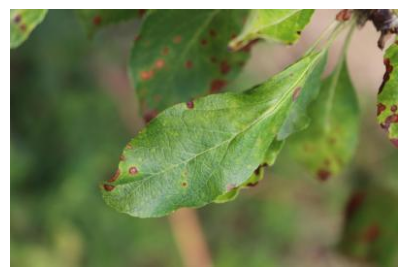

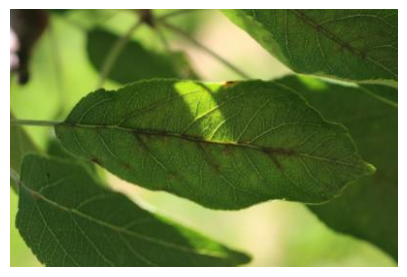

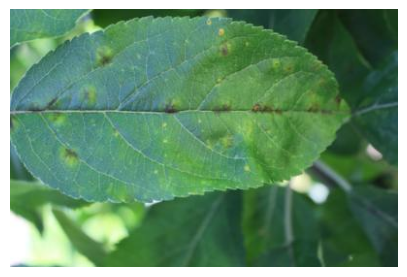

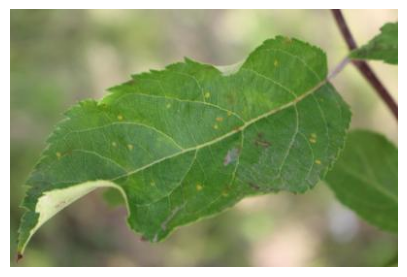

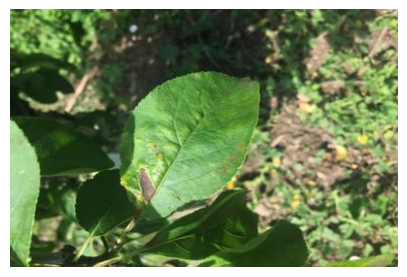

In [ ]:
from fastai.vision.utils import show_image

def display_most_certain_incorrect_preds(learn, n=5):
    # Define the hardcoded path
    image_folder_path = "/content/plant-pathology-2020-fgvc7/small_images"

    # Get predictions and targets
    all_preds = learn.get_preds()
    probs, targets = all_preds[0], all_preds[1]

    # Find incorrect predictions
    incorrect = probs.argmax(dim=1) != targets
    incorrect_probs, incorrect_indices = probs[incorrect].max(dim=1)

    # Sort them by certainty (highest probability)
    top_n_incorrect_indices = incorrect_probs.argsort(descending=True)[:n]

    # Actual indices in the validation set
    incorrect_actual_indices = torch.where(incorrect)[0][top_n_incorrect_indices]

    # Construct file paths for the images in the validation set
    filenames = learn.dls.valid.items['image_id'].tolist()
    valid_files = [f"{image_folder_path}/{name}.jpg" for name in filenames]

    # Get true labels for the validation set
    true_labels = [learn.dls.vocab[int(t)] for t in targets[incorrect_actual_indices]]
    pred_labels = [learn.dls.vocab[p.argmax().item()] for p in probs[incorrect_actual_indices]]


    # Display images with true labels
    for idx, file in enumerate(np.array(valid_files)[incorrect_actual_indices]):
        img = PILImage.create(file)
        show_image(img)
        print(f"True Label: {true_labels[idx]}, Predicted Label: {pred_labels[idx]}, p={probs[incorrect_actual_indices[idx]]}")

# Example usage:
display_most_certain_incorrect_preds(learn)

**Wrong labels !**

As it can be seen several of the 5 "wrong" classifications, are in fact not wrong classifications, but wrong labels! For example the first example has label "scab" but is clearly healthy with no signs of disease, which is what the model predicted (previous run..)

In [ ]:
interp = Interpretation.from_learner(learn)

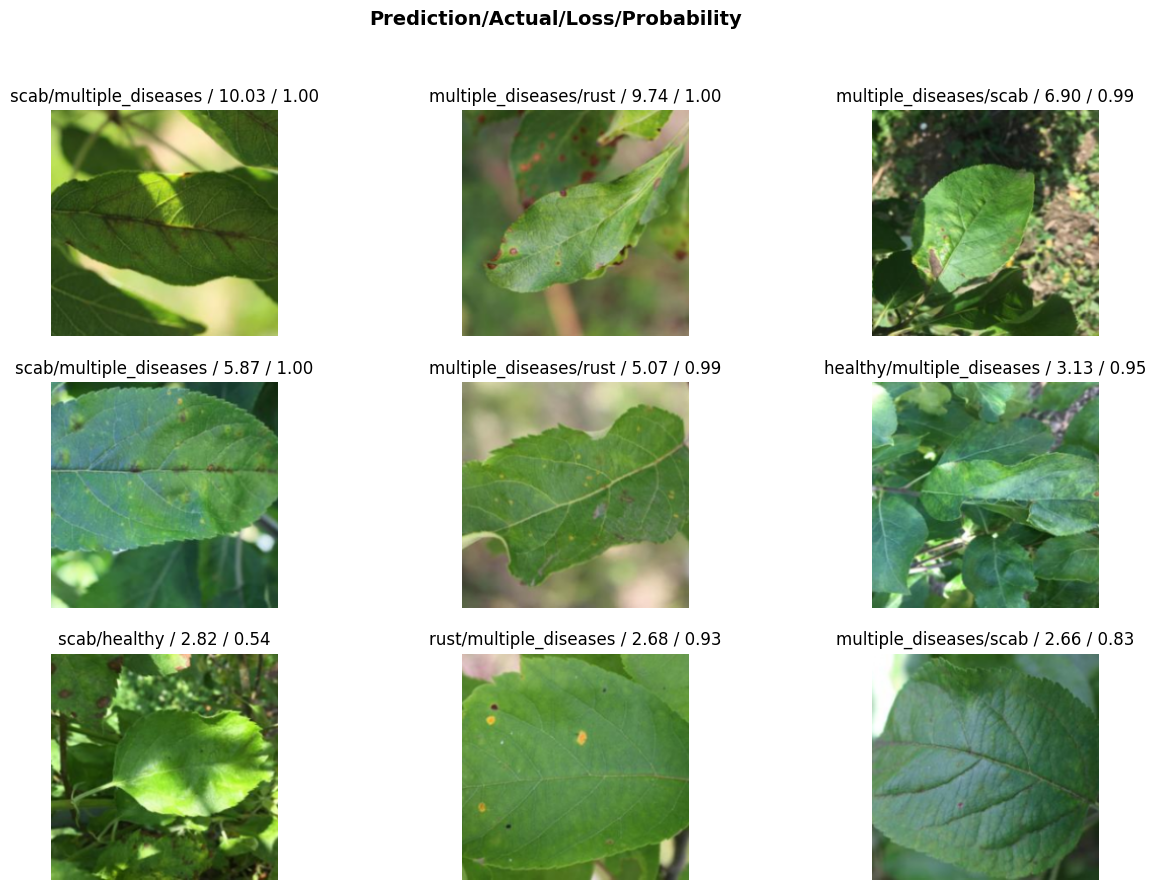

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

## Label smoothing
A regularization technique that introduces "noise" for the labels in order to account for wrongful labeling. Introduces a constant epsillon to the training set so that the one-hot (0 & 1s) labels are replaced by 1-e and e/k-1 so that a labels at epsillon 0.05 eg. becomes [0.016, 0.016, 0.95, 0.016]
https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06

Label smoothing in FastAI is simply done by replacing the loss function and setting the smoothing factor epsilon

In [44]:
#Function for easily swapping item transform and aug
#Added early stopping for longer train runs
from fastai.callback.wandb import *
from fastai.metrics import RocAuc

def train_model(arch, item, batch, epochs, batch_size=64, learning_rate=0.005, accum_steps=4, wandb_flag=False):

  config = {
      'arch': arch,
      'item_tfms_size': str(item.size),
      'item_tfms_method': item.method,
      'item_tfms_padding': item.pad_mode,
      'learning_rate': learning_rate,
      'epochs': epochs,
      'notes': 'label smoothing e=0.1'
  }

  if wandb_flag:
    wandb.init(project='apple_disease', entity='jealk', group='large_model_architecture', config=config)

  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=item,
                               bs=batch_size//accum_steps,
                               batch_tfms=batch,
                               )

  loss_func = LabelSmoothingCrossEntropyFlat(eps=0.1)

  learn = vision_learner(dls, arch, metrics=RocAuc(), pretrained=True, loss_func=loss_func).to_fp16()

  early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=2)

  callbacks = [early_stopping_cb, SaveModelCallback(monitor='valid_loss')]

  if wandb_flag:
    callbacks.append(WandbCallback(log=None,log_preds=False,log_model=True, log_preds_every_epoch=True))

  if accum_steps > 1:
    gradient_accumulation_cb = GradientAccumulation(accum_steps)
    callbacks.append(gradient_accumulation_cb)

  learn.fine_tune(epochs,learning_rate, cbs=callbacks)

  if wandb_flag:
    recorder = learn.recorder
    min_loss, max_roc = best_loss_roc(recorder)
    wandb.log({"best_loss": min_loss})  # Logging the lowest loss value to wandb
    wandb.log({"best_roc": max_roc})  # Logging the ROC value of the lowest loss model to wandb
    wandb.finish()

  if wandb_flag:
    wandb.finish()

  return learn, dls


In [ ]:
model_archs = [('convnext_large.fb_in22k'),
               ('vit_large_patch16_224.augreg_in21k')]

for model in model_archs:
  arch = model
  learn,dls = train_model(arch,
                          item=Resize(256, method='crop'),
                          batch=aug_transforms(size=224, min_scale=0.75),
                          epochs=30,
                          wandb_flag=True)

  #Attempt to clear colab GPU between runs does not work entirely.. seems to be a general issue
  report_gpu()
  model = None
  learn = None
  gc.collect()
  with torch.no_grad():
      torch.cuda.empty_cache()


epoch,train_loss,valid_loss,roc_auc_score,time
0,1.294697,0.839415,0.928408,00:34


Better model found at epoch 0 with valid_loss value: 0.8394147157669067.


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.825509,0.620736,0.959591,00:47
1,0.695998,0.626234,0.954202,00:45
2,0.662584,0.519206,0.975824,00:45
3,0.621643,0.520440,0.984293,00:47
4,0.565485,0.503565,0.969173,00:50
5,0.534429,0.486732,0.969168,00:47
6,0.504882,0.508662,0.970252,00:49
7,0.506356,0.454584,0.977559,00:47
8,0.481430,0.461131,0.969307,00:49
9,0.471379,0.487496,0.975675,00:45


Better model found at epoch 0 with valid_loss value: 0.620735764503479.
Better model found at epoch 2 with valid_loss value: 0.5192058086395264.
Better model found at epoch 4 with valid_loss value: 0.50356525182724.
Better model found at epoch 5 with valid_loss value: 0.4867315888404846.
Better model found at epoch 7 with valid_loss value: 0.4545844793319702.
No improvement since epoch 7: early stopping
GPU:0
process       4870 uses     9164.000 MB GPU memory


In [112]:
learn,dls = train_model('vit_large_patch16_224.augreg_in21k',
                          item=Resize(256, method='crop'),
                          batch=aug_transforms(size=224, min_scale=0.75),
                          epochs=15,
                          wandb_flag=True)


epoch,train_loss,valid_loss,roc_auc_score,time
0,1.069731,0.750666,0.957179,00:35


Better model found at epoch 0 with valid_loss value: 0.7506657838821411.


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.715285,0.556478,0.972344,00:55
1,0.636556,0.499520,0.986264,00:55
2,0.554580,0.529204,0.977641,00:54
3,0.530136,0.543042,0.952903,00:53


Better model found at epoch 0 with valid_loss value: 0.5564780831336975.
Better model found at epoch 1 with valid_loss value: 0.49952030181884766.
No improvement since epoch 1: early stopping


**Save the model**

In [ ]:
#/content/drive/MyDrive/dtu/fastAI/10_final_project
learn.export("/content/drive/MyDrive/dtu/fastAI/10_final_project/models/vit_large_lbsmooth_ROC0992.pkl")

## Conclusion: No improvement with larger model & smoothing
**Limited testing due to fairly long compute time ~3 runs of each large model**
![Alt text](image-3.png)
There seem to be no performance increase of using the larger models even with label smoothing, compared to the ViT Small which indicates that the model can fit as good as it is possible to the training data, and further improvement might be found not model wise but in terms of preprocessing and labeling.

# Increasing image size
Another option to improve accuracy is to increase the image size (we downsized images heavily) to provide more information to the model.

Below we have resized images to 660x512 and will re-train the larger models on these to see if it improves performance.

ViT base is per model designed only applicable to the trained size, 224x224, therefore we will conduct training on larger images just with Convnext.

**Resizing images**

In [134]:
"""
def check_transpose(img):
    img_loaded = PILImage.create(img)
    if img_loaded.shape == (900,599):
        print('Flipped image: ', img)
        #Transpose the image 90 degrees and overwrite the original image
        img_rotated = img_loaded.rotate(90, expand=True)
        #img_rotated.show()
        #Save the image
        img_rotated.save(img)
        return img_rotated.shape
    else:
        return img_loaded.shape

image_sizes = parallel(check_transpose, image_path_medium, n_workers=n_cores)
"""

"\ndef check_transpose(img):\n    img_loaded = PILImage.create(img)\n    if img_loaded.shape == (900,599):\n        print('Flipped image: ', img)\n        #Transpose the image 90 degrees and overwrite the original image\n        img_rotated = img_loaded.rotate(90, expand=True)\n        #img_rotated.show()\n        #Save the image\n        img_rotated.save(img)\n        return img_rotated.shape\n    else:\n        return img_loaded.shape\n\nimage_sizes = parallel(check_transpose, image_path_medium, n_workers=n_cores)\n"

In [126]:
#Copy prev resized images from drive to Colab (They have all been pre-processed and flipped to same dim)
#Create new folder in /content/plant-pathology-2020-fgvc7/small_images
if colab_flag == True:
    !mkdir /content/plant-pathology-2020-fgvc7/medium_images
    !cp -r /content/drive/MyDrive/dtu/fastAI/10_final_project/medium_images/. '/content/plant-pathology-2020-fgvc7/medium_images'
    #Check the size of a photo in the small_images
    image_path_medium = path/'medium_images'
    image_path_medium = get_image_files(image_path_medium)
    sizes = parallel(check_size, image_path_medium, n_workers=n_cores)
    print(pd.Series(sizes).value_counts())


(511, 768)    3620
(768, 511)      22
dtype: int64


## Training with 512x512 size images (vs 224x224)

In [135]:
learn,dls = train_model('convnext_large.fb_in22k',
                          item=Resize(600, method='crop'),
                          batch=aug_transforms(size=512, min_scale=0.75),
                        accum_steps=8,
                          epochs=15,
                          wandb_flag=True)


epoch,train_loss,valid_loss,roc_auc_score,time
0,1.250915,1.032880,0.918332,02:04


Better model found at epoch 0 with valid_loss value: 1.0328800678253174.


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.830818,0.599609,0.959638,02:54
1,0.758786,0.549940,0.963364,02:52
2,0.701728,0.548759,0.957461,02:53
3,0.652548,0.510248,0.968241,02:52
4,0.610806,0.591623,0.953570,02:53
5,0.574768,0.466549,0.987519,02:59
6,0.547455,0.489433,0.978151,02:57
7,0.541159,0.463700,0.982639,02:53


Better model found at epoch 0 with valid_loss value: 0.599608838558197.
Better model found at epoch 1 with valid_loss value: 0.5499399304389954.
Better model found at epoch 2 with valid_loss value: 0.548759400844574.
Better model found at epoch 3 with valid_loss value: 0.5102484822273254.
Better model found at epoch 5 with valid_loss value: 0.46654924750328064.
Better model found at epoch 7 with valid_loss value: 0.46370047330856323.
No improvement since epoch 5: early stopping


In [136]:
#/content/drive/MyDrive/dtu/fastAI/10_final_project
learn.export("/content/drive/MyDrive/dtu/fastAI/10_final_project/models/conv_large_lbsmooth_512.pkl")

## Conclusion: No improvement with larger images (very limited testing: 1 run)
![Alt text](image-4.png)
The prelimenary conclusion is that the larger image size coupled with ConvNext did not produce notacibly better results than the ViT Small. However, very limited testing with higher res images have been conducted due to computational limitations, and it might still be possible that this is a way to improve performance.

## Soft Pseudo labeling [UNFINISHED ATEMPT - FAILED TO IMLEMENT IT IN THE FAST.AI LEARNER]
When working with labels that one expect are wrong, another way to balance the wrong labels is to introduce 'soft labeling' which is by changing the true labels of the train set to a mixture of the provided label, and the predicted label - if the model is very confident that a given sample is of another label.

For example, for labels which are wrongly classified as Scab, but in which the classifier is 95% or more confident that it is healthy, one can turn the one-hot-encoding into a float and mix the two labels so that the labels during training are instead 0.7 scab and 0.3 healthy, so that the model is less punished for these outliers and thereby might learn to generalize better.


In [ ]:
#ds_idx=0 for train set
preds,targets = learn.get_preds(ds_idx=0)

#get the idx of the train and valid set
train_idx = dls.train_ds.items
print(len(train_idx))
train_idx.head()

1457


,image_id,healthy,multiple_diseases,rust,scab,label
742,Train_742,0,0,1,0,rust
1570,Train_1570,0,0,0,1,scab
1253,Train_1253,0,0,1,0,rust
136,Train_136,1,0,0,0,healthy
1174,Train_1174,0,0,0,1,scab


In [ ]:
#Copy the train idx df and overwrite the label columns 2 to 5 with the preds
pred_df = train_idx.copy()
pred_df.iloc[:,1:5] = array(preds)
#Use argmax on columns to set the column values to either 0 or 1 (not bool)
pred_df.iloc[:,1:5] = pred_df.iloc[:,1:5].apply(lambda col: col == col.max(), axis=1)
pred_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
742,Train_742,False,False,True,False,rust
1570,Train_1570,False,False,False,True,scab
1253,Train_1253,False,False,True,False,rust
136,Train_136,True,False,False,False,healthy
1174,Train_1174,False,False,False,True,scab


In [ ]:
#Create a new dataframe where the columns are floats with a value of 0.7 x the train_idx value and 0.3 x the value of pred_df
soft_labels_train = pred_df.copy()
soft_labels_train.iloc[:,1:5] = 0.7 * train_idx.iloc[:,1:5] + 0.3 * pred_df.iloc[:,1:5]
soft_labels_train.head()


,image_id,healthy,multiple_diseases,rust,scab,label
742,Train_742,0.0,0.0,1.0,0.0,rust
1570,Train_1570,0.0,0.0,0.0,1.0,scab
1253,Train_1253,0.0,0.0,1.0,0.0,rust
136,Train_136,1.0,0.0,0.0,0.0,healthy
1174,Train_1174,0.0,0.0,0.0,1.0,scab


In [ ]:
#Convert column 1 to 5 to tensors
soft_labels_train.iloc[:,1:5] = soft_labels_train.iloc[:,1:5].astype('float32')

<ipython-input-25-105cb8ec5599>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  soft_labels_train.iloc[:,1:5] = soft_labels_train.iloc[:,1:5].astype('float32')


In [ ]:
def get_x(row):
    return path/'small_images'/f"{row['image_id']}.jpg"

def get_y(row):
    return row[soft_labels_train.columns[1:5]].values



In [ ]:
class SoftLabelTensor(TensorBase):
    _show_args = {'cmap': 'Blues'}

    @classmethod
    def create(cls, x):
        return cls(tensor(x))

    def show(self, ctx=None, **kwargs):
        return show_title(self, ctx, label=' '.join([f'{i}: {self[i]:.2f}' for i in range(self.shape[0])]), **{**self._show_args, **kwargs})

    def __format__(self, format_spec):
        # If you get a format spec you don't recognize,
        # you can pass it to the superclass's __format__
        return super().__format__(format_spec)


def SoftLabelBlock():
    return TransformBlock(type_tfms=SoftLabelTensor.create)



TypeError: ignored

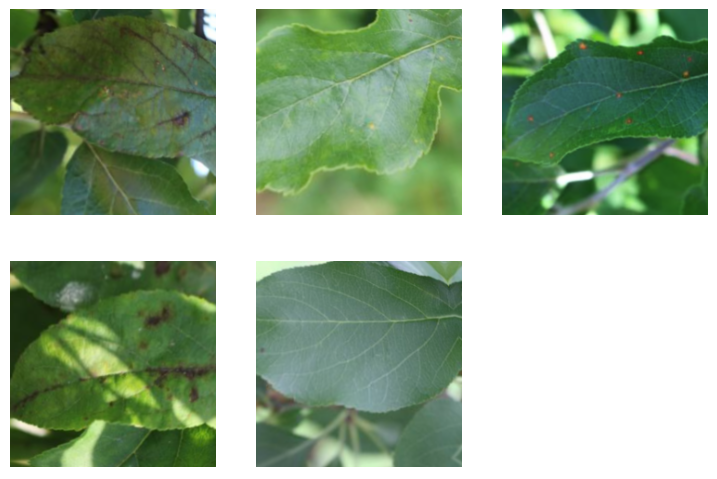

In [ ]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)  # 80-20 split with a seed for reproducibility

vocab = ['healthy', 'multiple_diseases', 'rust', 'scab']

dblock = DataBlock(blocks=(ImageBlock, SoftLabelBlock()),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=Resize(256, method='crop'),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)]
                  )


dls = dblock.dataloaders(df_train, bs=64)
dls.show_batch(max_n=5)


In [ ]:

loss_func = nn.BCEWithLogitsLoss()

learn = vision_learner(dls, 'vit_small_patch16_224.augreg_in21k_ft_in1k', pretrained=True, loss_func=loss_func).to_fp16()

learn.fine_tune(5,0.005)


In [ ]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)  # 80-20 split with a seed for reproducibility

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(vocab = ['healthy', 'multiple_diseases', 'rust', 'scab'])),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=Resize(256, method='crop'),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)]
                  )

dls = dblock.dataloaders(df_train, bs=64)

loss_func = BCEWithLogitsLossFlat()

learn_2 = vision_learner(dls, 'vit_small_patch16_224.augreg_in21k_ft_in1k', pretrained=True, loss_func=loss_func).to_fp16()

learn_2.fine_tune(5,0.005)

TypeError: ignored

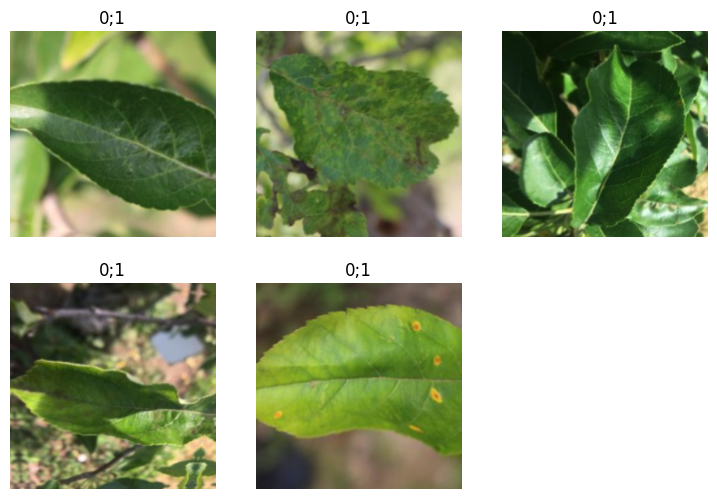

In [ ]:
dls.show_batch(max_n=5)